In [1]:
# Imports
import torch
import torch.nn as nn
import torchtext
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
from datetime import datetime

from torchtext.data import get_tokenizer

import random
import collections

from torchtext.transforms import Sequential, ToTensor
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#from torchtext.datasets import text_classification
# from torchtext.experimental.functional import sequential_transforms, vocab_func, totensor
# from torchtext.experimental.datasets.text_classification import TextClassificationDataset

from tqdm.notebook import tqdm
from datasets import load_dataset

In [2]:
# we load the sms spam dataset from the huggingface hub [source: https://huggingface.co/datasets/sms_spam]
raw_dataset = load_dataset('sms_spam')
raw_dataset

Found cached dataset sms_spam (/home/kpapdac/.cache/huggingface/datasets/sms_spam/plain_text/1.0.0/53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 5574
    })
})

In [3]:
data = [tuple([raw_dataset['train']['label'][i], raw_dataset['train']['sms'][i]]) for i in range(len(raw_dataset['train']['sms']))]

In [5]:
set([data[i][0] for i in range(len(raw_dataset['train']))])

{0, 1}

In [6]:
print(f'Number of Examples: {len(data)}')

Number of Examples: 5574


In [7]:
def get_train_test_split(data, split_ratio = 0.7):
    random.shuffle(data)
    
    n_train = int(len(data) * split_ratio)
    train_data = data[:n_train]
    test_data = data[n_train:]
    
    return train_data, test_data

In [8]:
train_data, test_data = get_train_test_split(data)

In [9]:
print(f'Number of Train Examples: {len(train_data)}')
print(f'Number of Test Examples: {len(test_data)}')

Number of Train Examples: 3901
Number of Test Examples: 1673


In [40]:
class Tokenizer:
    def __init__(self, tokenize_fn = 'basic_english', lower = True, max_length = None):
        
        self.tokenize_fn = torchtext.data.utils.get_tokenizer(tokenize_fn)
        self.lower = lower
        self.max_length = max_length
        
    def tokenize(self, s):
        
        tokens = self.tokenize_fn(s)
        
        if self.lower:
            tokens = [token.lower() for token in tokens]
            
        if self.max_length is not None:
            tokens = tokens[:self.max_length]
            
        return tokens

In [41]:
max_length=2500

tokenizer = Tokenizer(max_length=max_length)

In [42]:
s = 'ham but not'
print(tokenizer.tokenize(s))

['ham', 'but', 'not']


In [45]:
def build_vocab_from_data(data, tokenizer, **vocab_kwarg):
    
    token_freqs = collections.Counter()
    
    for label, text  in data:
        tokens = tokenizer.tokenize(text)
        token_freqs.update(tokens)
        
    vocab = torchtext.vocab.Vocab(token_freqs, **vocab_kwarg)
    
    return vocab, token_freqs

In [46]:
max_size = 25000

vocab, token_freqs = build_vocab_from_data(train_data, tokenizer)

In [47]:
print(f'Unique words in vocab: {len(vocab)}')

Unique words in vocab: 7619


In [48]:
token_freqs.most_common(5)

[('.', 7994), ('i', 2086), ('to', 1602), ('you', 1533), (',', 1376)]

In [10]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

train_dataloader = DataLoader(train_data, batch_size=8, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [11]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [20]:
from torchtext.vocab import build_vocab_from_iterator
tokenizer = get_tokenizer('basic_english')
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

num_class = len(set([label for (label, text) in train_data]))
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [22]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [23]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# Hyperparameters
EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
train_dataset = to_map_style_dataset(train_data)
test_dataset = to_map_style_dataset(test_data)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)



for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

-----------------------------------------------------------
| end of epoch   1 | time:  0.61s | valid accuracy    0.934 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  0.19s | valid accuracy    0.964 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  0.19s | valid accuracy    0.964 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time:  0.19s | valid accuracy    0.969 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time:  0.19s | valid accuracy    0.969 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time:  0.21s |

In [24]:
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Checking the results of test dataset.
test accuracy    0.977


In [25]:
ag_news_label = {0: "ham",
                 1: "spam"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

model = model.to("cpu")

print("This is a %s news" %ag_news_label[predict(ex_text_str, text_pipeline)])

This is a spam news


In [26]:
# Define the model
class LSTM(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
        super(LSTM, self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        self.embed = nn.Embedding(self.V, self.D)
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True)
        self.fc = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)


        out = self.embed(X)

        # get RNN unit output
        out, _ = self.rnn(out, (h0, c0))

        # max pool
        out, _ = torch.max(out, 1)

        # we only want h(T) at the final time step
        out = self.fc(out)
        return out

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [28]:
model = LSTM(len(vocab), 20, 15, 1, 1)
model.to(device)

LSTM(
  (embed): Embedding(7602, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [29]:
# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [30]:
class Trainer(object):
    def __init__(self,
                model,
                optim,
                loss_fn,
                device="cpu"):
        self.model = model
        self.optim = optim
        self.loss_fn = loss_fn
        self.device = device
        
    def fit(self,
            train_loader,
            test_loader,
            n_epochs: int=100,
            eval_inter: int=1):
        history = {}
        history['epoch'] = []
        history['training_acc'] = []
        history['test_acc'] = []
        history['training_loss'] = []
        history['test_loss'] = []
        # Training Loop

        history['p_test'] = []
        history['y_test'] = []
        p_test = np.array([]) # for listing all predictions - last epoch only
        y_test = np.array([]) # for listing all predictions - last epoch only

        for epoch in range(n_epochs):
            history['epoch'].append(epoch+1)
            
            self.model.train()
            
            train_loss = []
            n_correct = 0.
            n_total = 0.
            for inputs, targets in tqdm(train_loader, leave=False):
                targets = targets.view(-1, 1).float()
                # Move data to GPU
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # zero the gradient
                self.optim.zero_grad()

                # forward pass
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)

                # get prediction
                predictions = (outputs.detach().numpy() > 0) # for bcewithlogitsloss

                # update counts
                n_correct += (predictions == targets.numpy()).sum().item()
                n_total += targets.shape[0]

                # backward pass and optimize
                loss.backward()
                self.optim.step()

                train_loss.append(loss.item())

            train_loss = np.mean(train_loss)
            history['training_acc'].append(n_correct / n_total * 100) 
            # save losses
            history['training_loss'].append(train_loss) 
    
           
            self.model.eval()
            with torch.no_grad():
                test_loss = []
                n_correct = 0.
                n_total = 0.
                for inputs, targets in test_loader:
                    targets = targets.view(-1, 1).float()
                    # Move data to GPU
                    inputs, targets = inputs.to(self.device), targets.to(self.device)

                    # forward pass
                    outputs_test = self.model(inputs)
                    loss_test = self.loss_fn(outputs_test, targets)

                    # get prediction
                    predictions = (outputs_test.numpy() > 0) # for bcewithlogitsloss
        
                    # update list of predictions  - done for last epoch only!
                    if epoch == (n_epochs - 1):
                        p_test = np.concatenate((p_test, predictions.flatten()), axis=0)
                        y_test = np.concatenate((y_test, targets.flatten()), axis=0)

                    # update counts
                    n_correct += (targets.numpy() == predictions).sum().item()
                    n_total += targets.shape[0]

                    test_loss.append(loss_test.item())
            history['p_test'] = p_test
            history['y_test'] = y_test
            test_loss = np.mean(test_loss)
            history['test_acc'].append(n_correct / n_total * 100) 
            # save losses
            history['test_loss'].append(test_loss) 
            
            if (epoch +1) % eval_inter == 0:
                print(f"Epoch: {epoch+1}/{n_epochs}, Train Accuracy: {history['training_acc'][-1]:.2f}%, Test Accuracy: {history['test_acc'][-1]:.2f}%, Train Loss: {history['training_loss'][-1]:.4f}, Test Loss: {history['test_loss'][-1]:.4f}", end='')
        return history



In [32]:
trainer = Trainer(model, optimizer, loss_fn,device)
history={}
history = trainer.fit(train_dataloader,test_dataloader,15,1)

  0%|          | 0/58 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

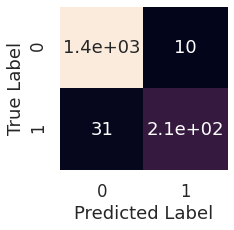

In [30]:
from sklearn.metrics import confusion_matrix

import seaborn as sns

# Set font scale
sns.set(font_scale=1.5)

# Create a confusion matrix
conf_mat = confusion_matrix(history['y_test'], history['p_test'])


def plot_conf_mat_sb(conf_mat):
    """
    Plots a confusion matrix using seaborn's heatmap
    """
    
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(conf_mat,
                    annot=True,
                    cbar=False)
    
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

plot_conf_mat_sb(conf_mat)